In [18]:
import os
from os.path import join
from Bio import Phylo
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from datetime import datetime

MODEL = 'S6A'
LOG_FORMAT = '%(asctime)s - %(levelname)s - %(message)s'

# ─── PARAMETERS ────────────────────────────────────────────────────────────────
DIR_WORKING = "/Users/u7875558/RNAPhylo/fullAlignment_S6A"
DIR_OUTPUTS = join(DIR_WORKING, "outputs")
DIR_RF = join(DIR_OUTPUTS, 'Robinson_Foulds_iqtree3')
DIR_RF_LOGS = join(DIR_WORKING, "logs", "RF_distance")
os.makedirs(DIR_RF_LOGS, exist_ok=True)

SUFFIXES     = {
    'DNA vs DNA':  '.raxml.rfdist',
    'DNA vs RNA':  '.raxml.raxmlPi.rfdist',
}

# A. Produce a dataframe containing all normalised RF distances of FULL dataset (only S6A model)

In [19]:
# control the number of RF distance files -- There should be 3
for rna in os.listdir(DIR_RF):
    rfdist_file = 0
    rna_path = join(DIR_RF, rna)
    if os.path.isdir(rna_path):
        for f in os.listdir(rna_path):
            if f.endswith('rfdist'):
                rfdist_file += 1
        
    if rfdist_file!=3:
        print(rna)

In [20]:
# ─── UTILITY FUNCTIONS ────────────────────────────────────────────────────────

def read_rfdist(path):
    """Read an RF distance matrix file into a NumPy array."""
    with open(path) as f:
        lines = f.readlines()[1:]  # skip header
    mat = [list(map(float, row.strip().split()[1:])) for row in lines]
    return np.array(mat)

def summarize_normalized(mat):
    """L2-normalize a matrix and return its mean and median (flattened)."""
    norm = normalize(mat, norm='l2')
    flat = norm.flatten()
    return float(flat.mean()), float(np.median(flat))

# ─── MAIN PROCESSING ──────────────────────────────────────────────────────────

log_filename = os.path.join(DIR_RF_LOGS, f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.medianRF.{MODEL}.log")
logging.basicConfig(filename=log_filename, level=logging.DEBUG, format=LOG_FORMAT)
logging.info(f"Running the code with the model {MODEL}.")

all_records = []

for rna in os.listdir(DIR_RF):
    rna_dir = join(DIR_RF, rna)
    
    for category, suffix in SUFFIXES.items():
        file_path = join(rna_dir, f"{rna}{suffix}")

        if not os.path.exists(file_path):
            continue
        mat = read_rfdist(file_path)
        mean_rf, med_rf = summarize_normalized(mat)

        all_records.append({
            'RNA': rna,
            'Category': category,
            'Mean RF': mean_rf,
            'Median RF': med_rf
        })

df = pd.DataFrame(all_records)

In [21]:
df

,RNA,Category,Mean RF,Median RF
0,RF04271,DNA vs DNA,0.299427,0.332923
1,RF04271,DNA vs RNA,0.316130,0.316537
2,RF03054,DNA vs DNA,0.299661,0.333217
3,RF03054,DNA vs RNA,0.316118,0.315240
4,RF03266,DNA vs DNA,0.120000,0.000000
...,...,...,...,...
5651,RF02935,DNA vs RNA,0.316145,0.316068
5652,RF03813,DNA vs DNA,0.298557,0.329315
5653,RF03813,DNA vs RNA,0.316207,0.315896
5654,RF01912,DNA vs DNA,0.299874,0.331593


In [29]:
# sort out RNA families having median RF > 0.3
df[df['Median RF'] > 0.3]['RNA'].drop_duplicates()

0       RF04271
2       RF03054
5       RF03266
7       RF01531
10      RF00087
         ...   
5647    RF00834
5648    RF00008
5650    RF02935
5652    RF03813
5654    RF01912
Name: RNA, Length: 2431, dtype: object

In [27]:
df[df['RNA']=='RF03266']

,RNA,Category,Mean RF,Median RF
4,RF03266,DNA vs DNA,0.120000,0.000000
5,RF03266,DNA vs RNA,0.316228,0.316228


# B. Figures

/var/folders/7l/28yzqfm93j105y85x5rns4bryc93vy/T/ipykernel_78382/2746332225.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


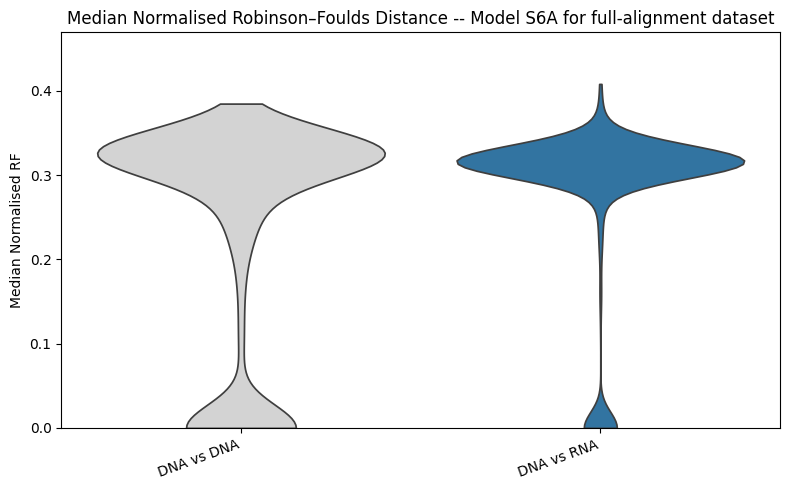

Group medians:
Category
DNA vs DNA    0.3196
DNA vs RNA    0.3162
Name: Median RF, dtype: float64

Group means:
Category
DNA vs DNA    0.2386
DNA vs RNA    0.2852
Name: Median RF, dtype: float64


In [22]:
# We’ll plot only these two categories from this table
order = ['DNA vs DNA', 'DNA vs RNA']

# Keep only rows we need and drop any NaNs in the y column
df_plot = (
    df[df['Category'].isin(order)]
      .copy()
      .dropna(subset=['Median RF'])
)

# Colors: light gray for DNA vs DNA; pick a distinct color for DNA vs RNA
palette = {
    'DNA vs DNA': 'lightgray',
    'DNA vs RNA': '#1f77b4',  # blue; change if you prefer another color
}

# Compute a little headroom for the y-axis
ymax = df_plot['Median RF'].max()

plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df_plot,
    x='Category',
    y='Median RF',
    order=order,
    palette=palette,
    cut=0,        # don’t extend beyond the data; keeps bottom at 0 cleanly
    inner=None    # no internal box/median lines
)

plt.ylim(0, ymax * 1.15)   # bottom pinned at 0; top auto with headroom
plt.xticks(rotation=20, ha='right')
plt.title('Median Normalised Robinson–Foulds Distance -- Model S6A for full-alignment dataset')
plt.ylabel('Median Normalised RF')
plt.xlabel('')
plt.tight_layout()
plt.show()

# (optional) print quick summaries
print("Group medians:")
print(df_plot.groupby('Category')['Median RF'].median().round(4))
print("\nGroup means:")
print(df_plot.groupby('Category')['Median RF'].mean().round(4))

/var/folders/7l/28yzqfm93j105y85x5rns4bryc93vy/T/ipykernel_78382/801219051.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


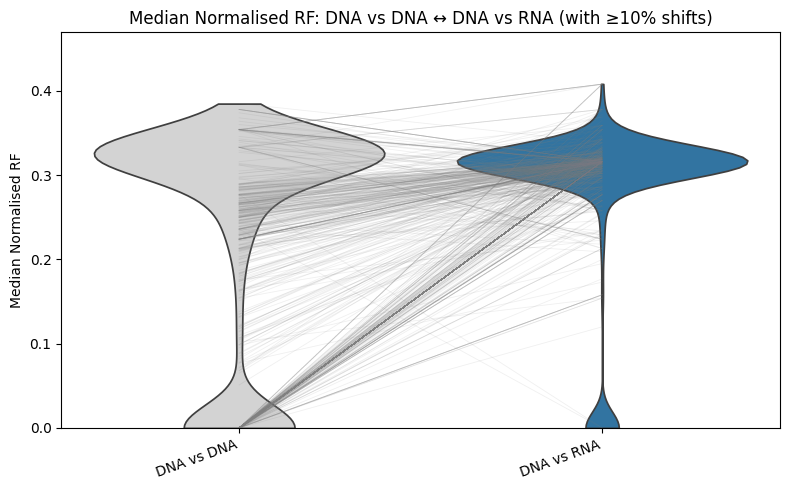

Lines drawn (≥10% change): 771 / 2828


In [23]:
# --- keep only the two categories we care about ---
order = ['DNA vs DNA', 'DNA vs RNA']
df_plot = (
    df[df['Category'].isin(order)]
      .copy()
      .dropna(subset=['Median RF'])
)

# --- colors ---
palette = {
    'DNA vs DNA': 'lightgray',   # baseline
    'DNA vs RNA': '#1f77b4',     # blue
}

# --- figure: violins first ---
ymax = df_plot['Median RF'].max()
plt.figure(figsize=(8, 5))
sns.violinplot(
    data=df_plot,
    x='Category',
    y='Median RF',
    order=order,
    palette=palette,
    cut=0,          # trim to actual min/max (bottom pinned at 0 by ylim below)
    inner=None
)

# --- connecting lines: only if >=10% relative change after rounding ---
THRESHOLD = 0.10   # 10%
ROUND = 3          # round to 3 decimals before comparing

# pivot to wide so each RNA has both values on one row
wide = (
    df_plot.pivot(index='RNA', columns='Category', values='Median RF')
           .reindex(columns=order)
)

lines_drawn = 0
for rna, row in wide.iterrows():
    v1, v2 = row['DNA vs DNA'], row['DNA vs RNA']
    if pd.isna(v1) or pd.isna(v2):
        continue
    # round to stabilize tiny numerical noise
    v1r, v2r = np.round(v1, ROUND), np.round(v2, ROUND)

    # relative change vs baseline (handle zero safely)
    if v1r > 0:
        rel = abs(v2r - v1r) / v1r
    else:
        rel = abs(v2r - v1r)  # fall back to absolute difference

    if rel >= THRESHOLD:
        plt.plot(
            [0, 1], [v1r, v2r],
            color='gray', alpha=0.12, linewidth=0.6, zorder=2
        )
        lines_drawn += 1

plt.ylim(0, ymax * 1.15)
plt.xticks(rotation=20, ha='right')
plt.title('Median Normalised RF: DNA vs DNA ↔ DNA vs RNA (with ≥10% shifts)')
plt.ylabel('Median Normalised RF')
plt.xlabel('')
plt.tight_layout()
plt.show()

print(f"Lines drawn (≥{int(THRESHOLD*100)}% change): {lines_drawn} / {wide.dropna().shape[0]}")
